In [1]:
!pip install pyro-ppl

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
import torch
import requests
import time
import json
import re
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer, StandardScaler

In [11]:
df = pd.read_csv("nicoseiga.tsv", sep="\t")
df = df.sample(50000, random_state=42)
df["FILTERED_TAGS"] = df["FILTERED_TAGS"].str.split(" ")

In [12]:
df

,CONTENTS_ID,HUID,HUID_NOHASH,TITLE,DESCRIPTION,WATCH_NUM,COMMENT_NUM,CREATE_DATETIME,UPDATE_DATETIME,TAGS,FILTERED_TAGS
181556,im11251375,88be9386ecf1fd3dcee8c9969c2f9973,116921195,おおおおおおおお‼‼‼‼,NaN,735,18,2023-08-14T14:36:37+09:00,2024-11-17T16:06:02+09:00,キャラクター クッキー☆ 小麦粉（クッキー☆） 牛乳（クッキー☆）,"[キャラクター, クッキー☆, 小麦粉（クッキー☆）, 牛乳（クッキー☆）]"
138357,im11150031,76722d4ec14f0513a705a50837333181,16379837,偽ゆひ,シユヂ並みのルーツなしオリキャラらしいけどデザインがすこ,1313,32,2023-03-15T19:25:41+09:00,2024-11-10T05:26:02+09:00,キャラクター クッキー☆ クッソー☆ 偽YUH,"[キャラクター, クッキー☆, クッソー☆]"
38113,im11272193,d2c350032c144b8449b812d66483ebc6,130188744,ねねちスマイル！,NaN,155,0,2023-09-16T12:11:40+09:00,2024-10-04T11:19:01+09:00,VTuber キャラクター バーチャルYouTuber ホロライブ 桃鈴ねね,"[VTuber, キャラクター, バーチャルYouTuber, ホロライブ, 桃鈴ねね]"
161906,im11261288,7ecca7fafee216590683b3518493b3ea,35828575,結束ぼっち,NaN,1392,4,2023-08-30T08:48:48+09:00,2024-11-17T08:11:02+09:00,くさそう ぼっち・ざ・ろっく！ キャラクター クンカクンカ ジャージ スカートもぐり 伊地知...,"[くさそう, ぼっち・ざ・ろっく！, キャラクター, クンカクンカ, ジャージ, スカートも..."
71481,im11338794,ccb27308826be525c622c9631e96c712,95970,フォードGT【改造モデル配布】,ロットんさんのフォードGTを少しだけいじったものを配布します。<br> 一部モデルにはまりり...,537,7,2023-12-28T07:16:08+09:00,2024-11-22T19:13:02+09:00,MMD MMDマシン配布あり MMDモデル配布あり MMDモータースポーツ MMD自動車 M...,"[MMD, MMDマシン配布あり, MMDモデル配布あり, MMDモータースポーツ, MMD..."
...,...,...,...,...,...,...,...,...,...,...,...
170607,im11244827,52aad6fb67e37c5e4d368d2ba6178bda,24401584,殺人鬼ＶＳあずきバー,NaN,885,9,2023-08-04T22:08:06+09:00,2024-11-22T01:30:03+09:00,Fate/Grand_Order MikuMikuDance ゲーム ジャック・ザ・リッパー...,"[Fate/Grand_Order, MikuMikuDance, ゲーム, ジャック・ザ・..."
4810,im11338237,4510c46cdda206e361547094362a121c,128554163,今日のジャケットGパン背面,今日の日課はジャケットGパン背面鳴花ヒメちゃんです,2836,46,2023-12-27T12:54:40+09:00,2024-11-22T04:29:01+09:00,VOICEROID ガイノイドTalk キャラクター ジーパン ジーンズ 尻 鳴花ヒメ,"[VOICEROID, ガイノイドTalk, キャラクター, ジーパン, ジーンズ, 尻, ..."
29416,im11263071,8b7d2dcb464de65392967cdd987c08d0,2868428,ディライラ,NaN,355,1,2023-09-02T08:03:04+09:00,2024-11-14T13:43:02+09:00,ギルティギア ゲーム,"[ギルティギア, ゲーム]"
113095,im11186334,97cff5eed740b0b8f666af019a8946b0,76985769,「紡乃世詞音、ただいま到着しましたっ！」,改めてA.I.VOICEの紡乃世詞音です！ あれ、どうしたんですかそんな突っ立って<br> ...,139,1,2023-05-10T07:55:02+09:00,2024-09-25T05:11:01+09:00,A.I.VOICE アナログ キャラクター モノクロ 紡乃世詞音,"[A.I.VOICE, アナログ, キャラクター, モノクロ, 紡乃世詞音]"


In [13]:
# タグの特徴量化
mlb = MultiLabelBinarizer()
tag_matrix = mlb.fit_transform(df["FILTERED_TAGS"])
df_tag = pd.DataFrame(tag_matrix, columns=mlb.classes_)

In [14]:
# 投稿者の特徴量化
id_encoder = OneHotEncoder(sparse_output=False)
id_matrix = id_encoder.fit_transform(df[["HUID_NOHASH"]])
id_columns = id_encoder.categories_[0]
df_illustrator = pd.DataFrame(id_matrix, columns=id_columns)

In [41]:

mode_target = 0.1
scale_initial = 0.5
loc_initial = np.log(mode_target) + scale_initial**2

def model(x_illustrators, x_tags, y):
    num_tags = x_tags.shape[1]
    num_illustrators = x_illustrators.shape[1]

    with pyro.plate("beta_tags_plate", num_tags):
        beta_tags = pyro.sample(
            "beta_tags",
            dist.LogNormal(
                torch.full((num_tags,), loc_initial),
                torch.full((num_tags,), scale_initial))
        )

    with pyro.plate("beta_illustrators_plate", num_illustrators):
        beta_illustrators = pyro.sample(
            "beta_illustrators",
            dist.LogNormal(
                torch.full((num_illustrators,), loc_initial),
                torch.full((num_illustrators,), scale_initial))
        )

    sigma = pyro.sample("sigma", dist.LogNormal(-2., 0.1))

    with pyro.plate("data", y.shape[0]):
        # あるイラストの人気は
        # 作者の技量 * (タグ1 + タグ2 + タグ3 + ...)
        # のように表すことができると仮定している
        y_tags = torch.matmul(x_tags, beta_tags)
        y_illustrators = torch.matmul(x_illustrators, beta_illustrators)
        y_hat = y_tags * y_illustrators
        pyro.sample("obs", dist.Normal(y_hat, sigma), obs=y)


def guide(x_illustrators, x_tags, y):
    num_tags = x_tags.shape[1]
    num_illustrators = x_illustrators.shape[1]

    beta_tags_loc = pyro.param("beta_tags_loc", torch.full((num_tags,), loc_initial))
    beta_tags_scale = pyro.param("beta_tags_scale", torch.full((num_tags,), scale_initial), constraint=dist.constraints.positive)

    beta_illustrators_loc = pyro.param("beta_illustrators_loc", torch.full((num_illustrators,), loc_initial))
    beta_illustrators_scale = pyro.param("beta_illustrators_scale", torch.full((num_illustrators,), scale_initial), constraint=dist.constraints.positive)

    with pyro.plate("beta_tags_plate", num_tags):
        pyro.sample("beta_tags", dist.LogNormal(beta_tags_loc, beta_tags_scale))

    with pyro.plate("beta_illustrators_plate", num_illustrators):
        pyro.sample("beta_illustrators", dist.LogNormal(beta_illustrators_loc, beta_illustrators_scale))

    sigma_loc = pyro.param("sigma_loc", torch.tensor(-2.0))
    sigma_scale = pyro.param("sigma_scale", torch.tensor(0.1), constraint=dist.constraints.positive)
    pyro.sample("sigma", dist.LogNormal(sigma_loc, sigma_scale))


In [51]:
object_variables = ["WATCH_NUM", "COMMENT_NUM"]
df_object_variables = df[object_variables].copy()

object_variables_ss = list(map(lambda x: f"{x}_ss", object_variables))
ss = StandardScaler()
standardized = ss.fit_transform(df_object_variables[object_variables])
df_object_variables[object_variables_ss] = standardized

x_tags = torch.Tensor(df_tag.values)
x_illustrators = torch.Tensor(df_illustrator.values)
y = torch.Tensor(df_object_variables["WATCH_NUM_ss"].values)
# y = torch.Tensor(df_object_variables["COMMENT_NUM_ss"].values)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0 Loss 4620.64535677433
Epoch 1 Loss 4016.767554283142
Epoch 2 Loss 943.9003667831421
Epoch 3 Loss 1875.6785477399826
Epoch 4 Loss 1870.5028638839722
Epoch 5 Loss 1055.5602250099182
Epoch 6 Loss 908.2929756641388
Epoch 7 Loss 1015.6160711050034
Epoch 8 Loss 1121.2374532222748
Epoch 9 Loss 1050.1797683238983
Epoch 10 Loss 1191.6584722995758
Epoch 11 Loss 978.2491334080696
Epoch 12 Loss 1023.8755782842636
Epoch 13 Loss 932.1310247182846
Epoch 14 Loss 966.0248465538025


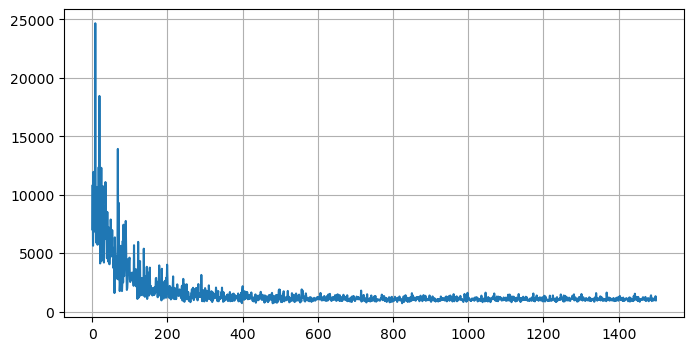

In [52]:

pyro.clear_param_store()

# オプティマイザの設定
optimizer = pyro.optim.Adam({"lr": 0.01})

# SVI (Stochastic Variational Inference)の設定
svi = pyro.infer.SVI(model, guide, optimizer, loss=pyro.infer.Trace_ELBO())

# データローダーの設定
batch_size = 500
dataset = TensorDataset(x_illustrators, x_tags, y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 学習ループ
num_iterations = 15
losses = []
for j in tqdm(range(num_iterations)):
    for batch_x_illustrators, batch_x_tags, batch_y in dataloader:
        loss = svi.step(batch_x_illustrators, batch_x_tags, batch_y)
        losses.append(loss)
    tqdm.write(f"Epoch {j} Loss {loss}")

plt.figure(figsize=(8, 4))
plt.grid()
plt.plot(range(len(losses)), losses)

array(-0.16259842, dtype=float32)

array(0.06726881, dtype=float32)

'===================='

'expectation'

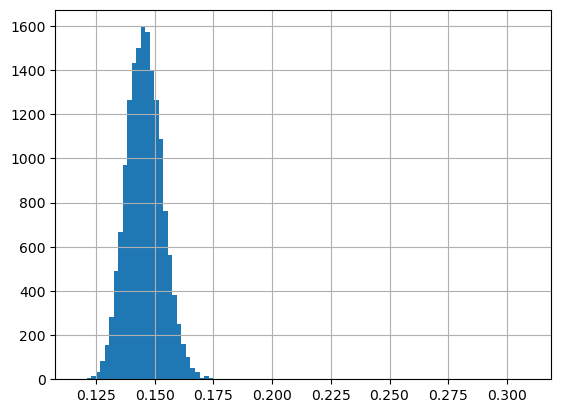

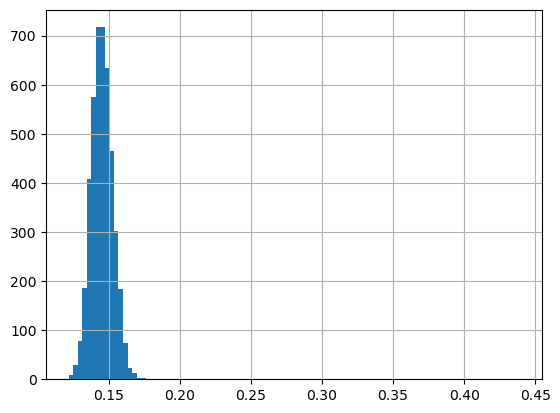

In [53]:
beta_tags_loc = pyro.param("beta_tags_loc").detach().numpy()
beta_tags_scale = pyro.param("beta_tags_scale").detach().numpy()
beta_illustrators_loc = pyro.param("beta_illustrators_loc").detach().numpy()
beta_illustrators_scale = pyro.param("beta_illustrators_scale").detach().numpy()

sigma_loc = pyro.param("sigma_loc")
sigma_scale = pyro.param("sigma_scale")

df_tags_predicted = pd.DataFrame([beta_tags_loc, beta_tags_scale], columns=df_tag.columns, index=["loc", "scale"]).T
df_illustrators_predicted = pd.DataFrame([beta_illustrators_loc, beta_illustrators_scale], columns=df_illustrator.columns, index=["loc", "scale"]).T

df_tags_predicted["expectation"] = np.exp(df_tags_predicted["loc"]+(df_tags_predicted["scale"]**2/2))
df_illustrators_predicted["expectation"] = np.exp(df_illustrators_predicted["loc"]+(df_illustrators_predicted["scale"]**2/2))

display(sigma_loc.detach().numpy())
display(sigma_scale.detach().numpy())
# display("loc")
# df_tags_predicted["loc"].hist(bins=100)
# plt.show()
# df_illustrators_predicted["loc"].hist(bins=100)
# plt.show()
# display("="*20)
# display("scale")
# df_tags_predicted["scale"].hist(bins=100)
# plt.show()
# df_illustrators_predicted["scale"].hist(bins=100)
# plt.show()
display("="*20)
display("expectation")
df_tags_predicted["expectation"].hist(bins=100)
plt.show()
df_illustrators_predicted["expectation"].hist(bins=100)
plt.show()

In [60]:
df_tags_predicted["cv"] = df_tags_predicted["expectation"] / df_tags_predicted["scale"]

# display(df_tags_predicted.sort_values("cv", ascending=False).head(50))
# display(df_tags_predicted.sort_values("cv").head(50))
display(df_tags_predicted.sort_values("expectation", ascending=False).head(50))
display(df_tags_predicted.sort_values("expectation").head(50))

,loc,scale,expectation,cv
ウマ娘,-1.366199,0.620699,0.309262,0.498248
ウマ娘プリティーダービー,-1.800137,0.581633,0.195736,0.336528
クレープ,-1.851217,0.555342,0.183230,0.329940
エロマンガ先生,-1.885662,0.597420,0.181372,0.303592
イラストメイキング,-1.875117,0.523600,0.175865,0.335877
変な犬兄貴,-1.873123,0.517284,0.175638,0.339538
マイナン,-1.908508,0.579656,0.175431,0.302647
いい夫婦の日,-1.861767,0.473394,0.173823,0.367185
こえ燭,-1.882320,0.509182,0.173308,0.340365
マスタースパーク,-1.924605,0.585835,0.173253,0.295737


,loc,scale,expectation,cv
キャラクター,-2.252888,0.467912,0.117253,0.250589
王様,-2.223274,0.466787,0.120714,0.258607
野生解放,-2.224924,0.477837,0.121146,0.253530
ウサ耳,-2.205928,0.438748,0.121277,0.276416
もう全部あいつ一人でいいんじゃないかな,-2.198873,0.432624,0.121810,0.281562
南国少年パプワくん,-2.224410,0.489975,0.121922,0.248834
ダンタリアンの書架,-2.225880,0.499710,0.122331,0.244804
おかえりなさい,-2.211711,0.482621,0.123040,0.254940
マルゼンスキー(ウマ娘),-2.228079,0.518577,0.123240,0.237651
緑仙,-2.202179,0.467075,0.123304,0.263993


In [61]:
df_illustrators_predicted["cv"] = df_illustrators_predicted["expectation"] / df_illustrators_predicted["scale"]**2

display(df_illustrators_predicted.sort_values("expectation", ascending=False).head(50))
display(df_illustrators_predicted.sort_values("expectation").head(50))

,loc,scale,expectation,cv
142321,-1.068045,0.700125,0.439131,0.895866
22108168,-1.706584,0.616531,0.219472,0.577391
20454577,-1.878764,0.525766,0.175424,0.634607
29897869,-1.883157,0.530180,0.175063,0.622798
42206395,-1.918882,0.560409,0.171726,0.546798
130458576,-1.930506,0.564397,0.170123,0.534064
16479674,-1.905576,0.514969,0.169826,0.640388
118385074,-1.910717,0.516867,0.169121,0.633053
8821886,-1.927687,0.547685,0.169025,0.563495
8580418,-1.903544,0.499935,0.168878,0.675690


,loc,scale,expectation,cv
15604322,-2.195889,0.430811,0.122079,0.657757
31207428,-2.216318,0.485268,0.122631,0.520760
205589,-2.226166,0.505570,0.122657,0.479875
17728208,-2.210810,0.480492,0.123024,0.532866
1964044,-2.203657,0.475620,0.123619,0.546470
12897471,-2.201874,0.474020,0.123746,0.550728
119506338,-2.205824,0.486201,0.123981,0.524473
888211,-2.195968,0.465603,0.123988,0.571934
6813868,-2.192571,0.479007,0.125200,0.545655
61742531,-2.170390,0.431635,0.125276,0.672410


In [58]:
df_illustrators_predicted.to_csv("illustrators.csv")
df_tags_predicted.to_csv("tags.csv")